# MOwNiT 

## Laboratorium 3

### Interpolacja

Przed uruchomieniem trzeba zainstalować pakiet:

```julia
Pkg.add("Interpolations")
```

In [1]:
using Plots

In [2]:
# wylosowanie węzłów interpolacji
xs =  1:1:10
ys = [rand() for x in xs]

10-element Array{Float64,1}:
 0.4598068923984462
 0.9781942735748583
 0.08773430179109654
 0.2249481147423784
 0.7662506030897633
 0.1728973613563458
 0.8762286175756879
 0.7732642649500394
 0.12204489859283729
 0.8142282501022042

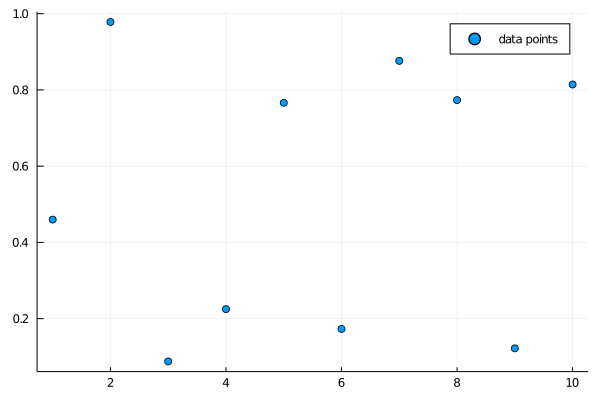

In [3]:
scatter(xs,ys, label="data points")

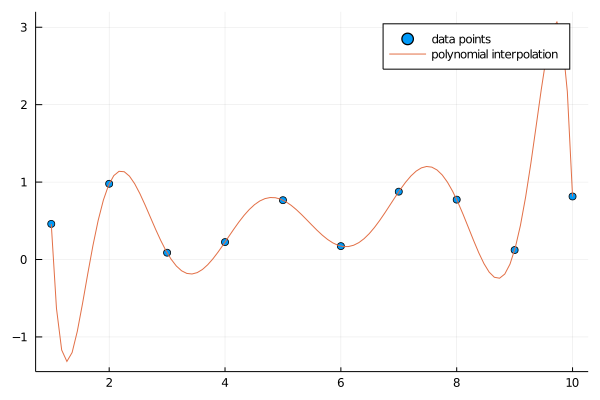

In [4]:
# interpolacja wielomianowa w pakiecie Polynomials
# https://juliamath.github.io/Polynomials.jl/stable/

# Fit a polynomial (of degree deg) to x and y using polynomial interpolation or a (weighted) least-squares approximation.
using Polynomials
f=fit(xs, ys)  # degree = length(xs) - 1 == 9
plot!(f,  extrema(xs)..., label="polynomial interpolation")

In [5]:
# gęste punkty do rysowania wykresów funkcji interpolujacych
xsf=1:0.01:10

1.0:0.01:10.0

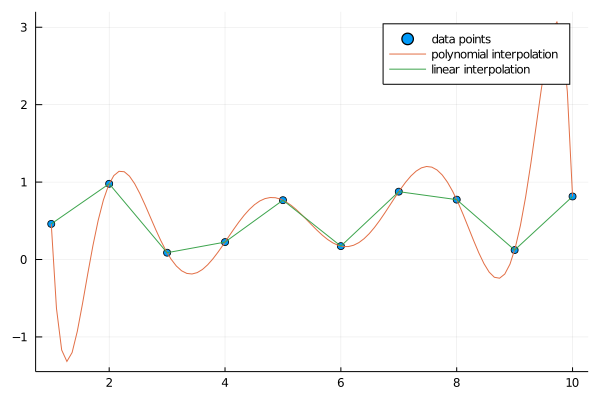

In [6]:
#  interpolacja liniowa z pakietu Interpolations - przykład
using Interpolations
interp_linear = LinearInterpolation(xs, ys)
ysf=[interp_linear(x) for x in xsf]
plot!(xsf,ysf, label="linear interpolation")

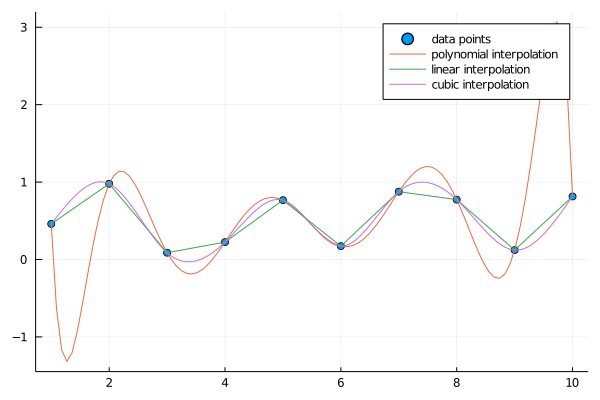

In [7]:
# interpolacja szescienna 
interp_cubic = CubicSplineInterpolation(xs, ys)
ysf2=[interp_cubic(x) for x in xsf]
plot!(xsf,ysf2, label="cubic interpolation")

In [8]:
#Interpolacja szescienna to BSpline z warunkami brzegowymi Line i OnGrid. 
#Więcej o konfiguracji warunkow brzegowych w
# dokumentacji https://github.com/JuliaMath/Interpolations.jl/blob/master/doc/Interpolations_algebra.pdf
interp_cubic

10-element extrapolate(scale(interpolate(OffsetArray(::Array{Float64,1}, 0:11), BSpline(Cubic(Line(OnGrid())))), (1:1:10,)), Throw()) with element type Float64:
 0.4598068923984461
 0.9781942735748586
 0.08773430179109654
 0.22494811474237839
 0.7662506030897633
 0.17289736135634576
 0.8762286175756879
 0.7732642649500394
 0.12204489859283729
 0.8142282501022041

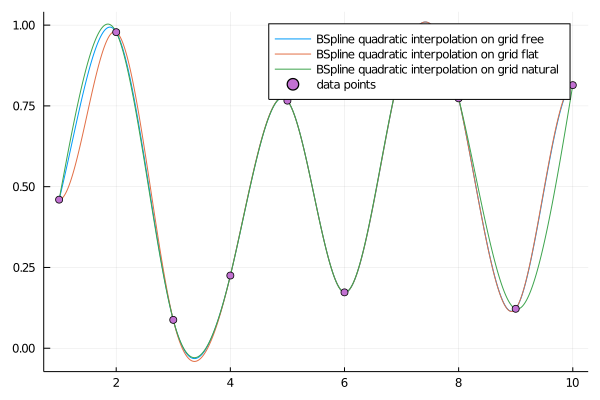

In [9]:
# Przyklad konfiguracji  BSpline-ów
itp = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot(xsf,ysf3, label="BSpline quadratic interpolation on grid free")
itp = interpolate(ys, BSpline(Cubic(Flat(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline quadratic interpolation on grid flat")
itp = interpolate(ys, BSpline(Cubic(Natural(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline quadratic interpolation on grid natural")

scatter!(xs,ys, label="data points")


### Zadania
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

1. Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

1. Zastosowac interpolację wielomianową z pakietu Polynomials  do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

1. Porownać  metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Jako narzedzie do analizy danych użyć Julia DataFrames. <b>(2 pkt)</b>

1. Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

1. Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

## Zad 1.
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

$P_n(x) = \sum_{k=0}^{n} f(x_k) \cdot L_k(x)$ 

$L_k(x) = \prod_{i=0,i\neq k}^{n} \frac{x-x_i}{x_k-x_i}$

### Implementacja

In [10]:
# y = f(x) = (x - x1)(x - x2)...(x - xn) * y0/(x0 - x1)(x0 - x2)...(x0 - xn) 
#                                  +
#            (x - x0)(x - x2)...(x - xn) * y1/(x1 - x0)(x1 - x2)...(x1 - xn)
#                              + .... +
#            (x - x1)(x - x2)...(x - xn-1) * yn/(xn - x0)(xn - x1)...(xn - xn-1)

function LagrangeInterpolation(xs, ys, x)
    res = 0
    for k in 1:1:length(ys)
        # count yk * Lk(x)
        yk = ys[k]
        Lk = 1
        for i in 1:1:length(xs)
            if i != k
                Lk *= (x - xs[i])/(xs[k] - xs[i]) 
            end
        end
        yk *= Lk
        res += yk
    end
    return res
end
    

LagrangeInterpolation (generic function with 1 method)

### Test

In [11]:
n = 10  # number of points
x_interval = [0 20]
y_interval = [0 30]

xs = [rand()*((x_interval[2] - x_interval[1]) + x_interval[1]) for x in 1:n]
ys = [rand()*((y_interval[2] - y_interval[1]) + y_interval[1]) for y in 1:n]

10-element Array{Float64,1}:
 27.577116331432286
 21.952614916120677
  5.907196940417343
 14.058717086708503
 21.244661074789494
 11.078740571942543
 21.34596194887489
 20.586276582309274
 22.411299768982126
  3.049682145968169

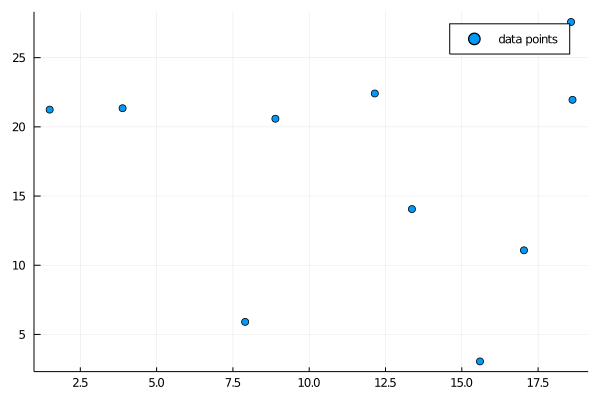

In [12]:
scatter(xs, ys, label = "data points")

In [13]:
xs2 = minimum(xs):0.1:maximum(xs)
ys2 = [LagrangeInterpolation(xs,ys,x) for x in xs2]

172-element Array{Float64,1}:
   21.244661074789494
  -85.92714098030814
 -169.8007555755365
 -233.4213406180287
 -279.54956897092035
 -310.6813946283772
 -329.0668045423743
 -336.72759287542596
 -335.47419360521025
 -326.921606568215
 -312.5044512001055
 -293.4911814105441
 -270.99749421961576
    ⋮
   26.78551593023055
   30.689261882814662
   34.53663693840604
   38.166945786143856
   41.382904542202084
   43.94592416780931
   45.571002301012385
   45.92120260348516
   44.601700064457965
   41.15337003518735
   35.04589808931627
   25.670387116974876

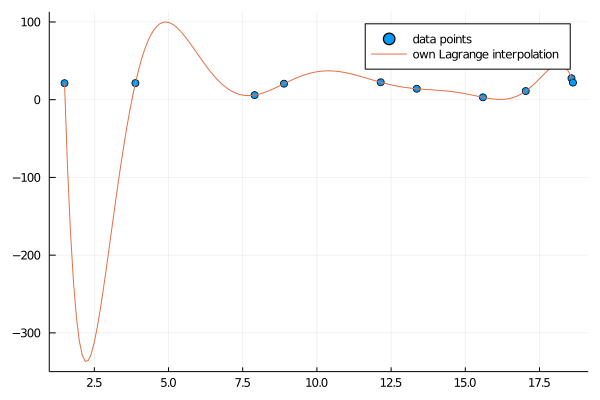

In [14]:
plot!(xs2, ys2, label = "own Lagrange interpolation")

## Zad 2.
Zrobic to samo dla metody  Newtona (metoda ilorazów różnicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   2. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

$P_n(x) = f[x_0] + \sum_{k=1}^{n} f[x_0,x_1,...,x_k](x-x_0)\cdot...\cdot(x-x_{k-1})$

#### Postać Newtona:

$W(x) = \sum_{k=0}^{n} b_kp_k(x)$

$p_0(x) = 1$

$p_k(x) = (x-x_0)(x-x_1)\cdot...\cdot(x-x_{k-1})$

#### Algorytm Hornera dla postaci Newtona:
$W_n = b_n$

$W_i = W_{i+1}\cdot(x-x_i)+b_i$

$W(x) = W_0$

In [15]:
 function NewtonInterpolation(xs,ys)
    n = length(xs)
    matrix = zeros(n,n)
    
    # first col
    for row in 1:1:n
        matrix[row,1] = ys[row]
    end
    
    for col in 2:1:n
        for row in col:n
            matrix[row,col] = (matrix[row,col-1] - matrix[row-1,col-1])/(xs[row] - xs[row-col+1])
        end
    end
    
    newt = zeros(n)
    for i in 1:1:n
        newt[i] = matrix[i,i]
    end
    
    return newt
end

NewtonInterpolation (generic function with 1 method)

In [16]:
newt = NewtonInterpolation(xs,ys)

10-element Array{Float64,1}:
   27.577116331432286
 -115.1634093720492
  -10.925249310823267
   -2.0960879169437003
   -0.12158790257822688
   -0.086273296631739
   -0.005972023718578005
   -0.0005038654494692853
   -9.966275678315338e-5
   -2.596384381835617e-5

In [17]:
function CalculateValue(newt,xs,x)
    n = length(xs)
    W = newt[n]
    for i in n-1:-1:1
        W = W*(x - xs[i]) + newt[i]
    end
    return W    
end

CalculateValue (generic function with 1 method)

In [18]:
xs3 = minimum(xs):0.1:maximum(xs)
ys3 = [CalculateValue(newt, xs, x) for x in xs3]

172-element Array{Float64,1}:
   21.244661074789754
  -85.92714098030842
 -169.8007555755368
 -233.42134061802878
 -279.5495689709203
 -310.68139462837695
 -329.0668045423745
 -336.72759287542556
 -335.47419360521
 -326.921606568215
 -312.50445120010494
 -293.49118141054487
 -270.99749421961576
    ⋮
   26.785515930230527
   30.68926188281466
   34.53663693840604
   38.16694578614388
   41.38290454220207
   43.94592416780931
   45.5710023010124
   45.921202603485185
   44.60170006445797
   41.15337003518738
   35.04589808931627
   25.670387116974865

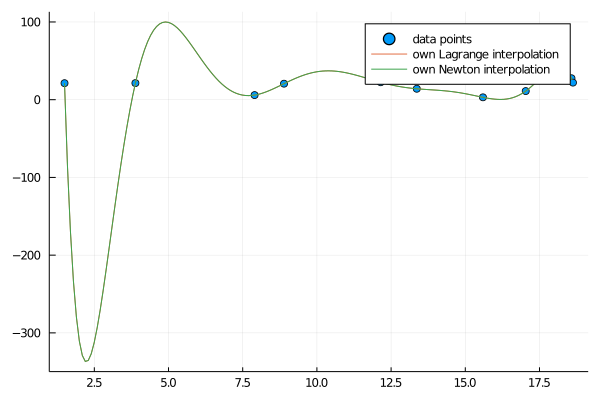

In [19]:
plot!(xs3, ys3, label = "own Newton interpolation")

## Zad 3.
Zastosowac interpolację wielomianową z pakietu Polynomials  do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

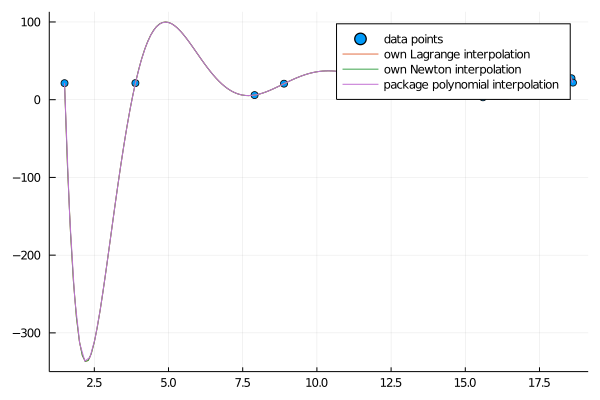

In [20]:
f=fit(xs, ys)  # degree = length(xs) - 1 == 9
plot!(f,  extrema(xs)..., label="package polynomial interpolation")


### Obserwacje:
Wszystkie 3 wyniki interpolacji są takie same, co widać na wykresie - krzywe nakładają sie na siebie. Wynika to z tego, że każda z metod wyznacza wielomian interpolujący jednoznacznie.

## Zad 4. 
Porownać  metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Jako narzedzie do analizy danych użyć Julia DataFrames. <b>(2 pkt)</b>

In [21]:
# polyfit, polyval from Polynomials package
# https://juliamath.github.io/Polynomials.jl/v0.4/
# ???

using Polynomials
using DataFrames

res = DataFrame(size = Int64[], i = Int64[], Lagrange = Float64[], polynomials = Float64[], Newton = Float64[], 
                Newton_pol = Float64[], Newton_val = Float64[])

for size in 20:20:260
    xs =  1:1:size
    ys = [rand() for x in xs]
    
    for i in 1:1:10
        xs2 = 1:0.1:size
        Lagrange = @elapsed [LagrangeInterpolation(xs,ys,x) for x in xs2]
        Newton_pol = @elapsed newt = NewtonInterpolation(xs,ys)
        Newton_val = @elapsed [CalculateValue(newt, xs, x) for x in xs2]
        Newton = Newton_pol + Newton_val
        polynomials = @elapsed fit(xs, ys)

        push!(res, [size i Lagrange polynomials Newton Newton_pol Newton_val])
    end
end

In [22]:
using Statistics
res_grouped = combine(groupby(res, :size), "Lagrange" => mean, "polynomials" => mean, "Newton" => mean,
                                           "Lagrange" => std, "polynomials" => std, "Newton" => std)

,size,Lagrange_mean,polynomials_mean,Newton_mean,Lagrange_std,polynomials_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,20,0.0160063,7.1899e-6,0.0222991,0.0482476,5.4816e-6
2,40,0.00538584,1.07304e-5,0.000133211,0.000142499,1.6631e-6
3,60,0.0177665,1.93199e-5,0.00026584,0.000297631,3.36894e-6
4,80,0.0371625,3.05099e-5,0.00043452,0.00439596,4.16187e-6
5,100,0.0733311,5.092e-5,0.00067607,0.00693779,1.77949e-5
6,120,0.131577,6.80007e-5,0.00102528,0.0312523,3.38826e-5
7,140,0.206897,8.02801e-5,0.0011443,0.0245526,1.32959e-5
8,160,0.278203,8.46997e-5,0.00170065,0.033814,1.70944e-5
9,180,0.376813,0.00010931,0.00180371,0.0556769,4.59301e-5


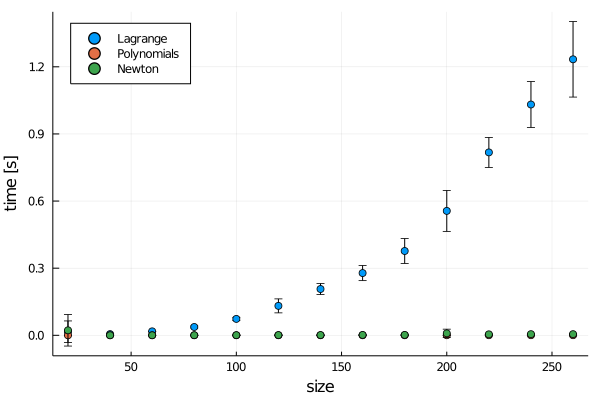

In [29]:
using Plots
scatter(res_grouped.size, res_grouped.Lagrange_mean, yerr=res_grouped.Lagrange_std, label = "Lagrange", 
        xlabel = "size", ylabel = "time [s]", legend=:topleft)
scatter!(res_grouped.size, res_grouped.polynomials_mean, yerr=res_grouped.polynomials_std, label = "Polynomials")
scatter!(res_grouped.size, res_grouped.Newton_mean, yerr=res_grouped.Newton_std, label ="Newton")

Najwolniejsza okazała się interpolacja Lagrange'a, pozostałe dwie metody są znacznie szybsze i bardzo do siebie zbliżone.

## Zad 5.
Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

## Zad 6.
Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

In [77]:
xs =  1:1:6
ys = [rand() for x in xs]

xs2 = 1:0.1:6

1.0:0.1:6.0

In [78]:
quad = interpolate(ys, BSpline(Quadratic(Line(OnCell()))))
quad_ys = [quad(x) for x in xs2]

cub = CubicSplineInterpolation(xs, ys)
cub_ys = [cub(x) for x in xs2]

cub2 = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
cub_ys2 = [cub2(x) for x in xs2]

f=fit(xs, ys) 

Polynomial(7.720237421214073 - 15.510659232396199*x + 11.187565716520036*x^2 - 3.631837935194587*x^3 + 0.5469243194426731*x^4 - 0.030992494303433323*x^5)

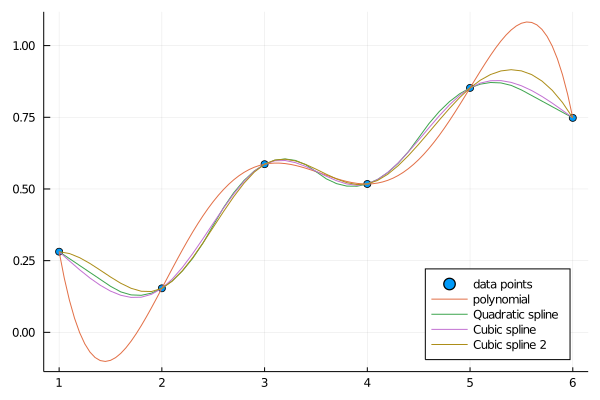

In [80]:
scatter(xs, ys, label = "data points", legend=:bottomright)
plot!(f,  extrema(xs)..., label="polynomial")
plot!(xs2, quad_ys, label = "Quadratic spline")
plot!(xs2, cub_ys, label = "Cubic spline")
plot!(xs2, cub_ys2, label = "Cubic spline 2")

Interpolacja funkcjami sklejanymi stopnia 2 czy 3 ma podobne rezultaty. Wyraźnie odstaje interpolacja wielomianowa.

#### Efekt Rungego

Pogorszenie jakości interpolacji wielomianowej, mimo zwiększenia liczby jej węzłów.
Takie zachowanie się wielomianu interpolującego jest zjawiskiem typowym dla interpolacji za pomocą wielomianów wysokich stopni przy stałych odległościach węzłów. Występuje ono również, jeśli interpolowana funkcja jest nieciągła albo odbiega znacząco od funkcji gładkiej.

Dla przykładu sprawdzimy wielomian stopnia 15, węzły równoodległe.

In [88]:
xs =  1:1:15
ys = [rand() for x in xs]
xs2 = 1:0.1:15

1.0:0.1:15.0

In [89]:
f=fit(xs, ys)

Polynomial(-4357.766492773349 + 13842.724404744618*x - 18578.128993394523*x^2 + 14201.62852880323*x^3 - 6989.553484699514*x^4 + 2363.654126411152*x^5 - 570.3261490826213*x^6 + 100.31421785515552*x^7 - 12.98529829221337*x^8 + 1.2358954219198535*x^9 - 0.08541871357892356*x^10 + 0.004168947222009447*x^11 - 0.0001361521298148609*x^12 + 2.668838955667514e-6*x^13 - 2.3732302932372146e-8*x^14)

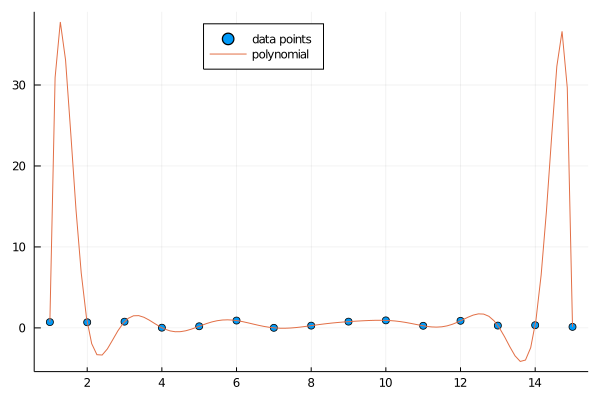

In [92]:
scatter(xs, ys, label = "data points", legend=:top)
plot!(f,  extrema(xs)..., label="polynomial")